In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import calendar
import tqdm
import itertools

# Customize plot settings
from latexify import *
from utils import *
golden_mean = (np.sqrt(5) - 1.0) / 2.0  # Aesthetic ratio

## Problem data

In [2]:
# Hourly loads
load_data = pd.read_pickle("data/load_data.pickle")
load_min = load_data.min()
load_max = load_data.max()

# Time-of-use prices
tou_price_data = pd.read_pickle("data/tou_price_data.pickle")

# Day-ahead spot prices
spot_prices_2020_2022 = pd.read_pickle("data/spot_price_data.pickle")
spot_prices_jan2023 = pd.read_pickle("data/spot_price_data_jan2023.pickle")
spot_price_data = pd.concat([spot_prices_2020_2022, spot_prices_jan2023])

# Load forecasting
load_baseline = pd.read_pickle("data/load_baseline.pickle")
AR_params = pd.read_pickle("data/AR_params.pickle")

# Spot price forecasting
spot_price_baseline = pd.read_pickle("data/spot_price_baseline.pickle")

# Define simulation window: one year (2022) with hourly resolution
T = 24 * 365
start_date = pd.Timestamp("2022-01-01 00:00:00")

sim_start_time = load_baseline.index.get_loc(start_date)
sim_end_time = sim_start_time + T
sim_datetime_index = load_data.index[sim_start_time:sim_end_time]

# Load and price values for 2022
load = load_data.iloc[sim_start_time:sim_end_time].values
tou_prices = tou_price_data.iloc[sim_start_time:sim_end_time].values
spot_prices = spot_price_data.iloc[sim_start_time:sim_end_time].values

## Baseline analysis: No storage

Total cost: 25,037.07 NOK
Energy cost related to time-of-use prices: 8,676.61 NOK (34.66% of total cost)
Energy cost related to day-ahead spot prices: 13,336.45 NOK (53.27% of total cost)
Peak power cost: 3,024.00 NOK (12.08% of total cost)


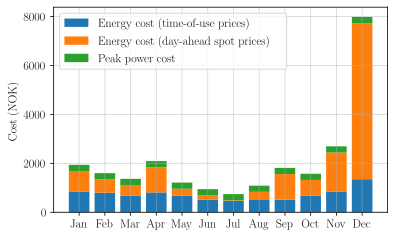

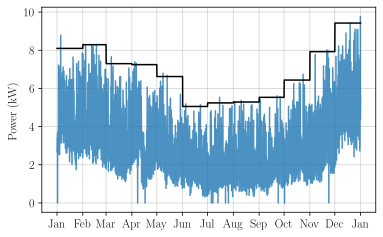

In [3]:
# Compute and print total cost with no storage
total_tou_cost, total_spot_cost, total_peak_cost = compute_total_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=load, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)
cost_no_storage = total_tou_cost + total_spot_cost + total_peak_cost
print_cost_summary(total_tou_cost, total_spot_cost, total_peak_cost)

# Plot montlhy cost breakdown
monthly_tou_costs, monthly_spot_costs, monthly_peak_costs = compute_monthly_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=load, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)
n_months = len(monthly_tou_costs)
months = range(1, n_months+1)

latexify(fig_width=6)
fig, ax = plt.subplots()
plt.bar(months, monthly_tou_costs, label='Energy cost (time-of-use prices)')
plt.bar(months, monthly_spot_costs, bottom=[i for i in monthly_tou_costs], label='Energy cost (day-ahead spot prices)')
plt.bar(months, monthly_peak_costs, bottom=[i+j for i,j in zip(monthly_tou_costs, monthly_spot_costs)], label='Peak power cost')
plt.xticks(months, [calendar.month_abbr[m] for m in months])
plt.ylabel('Cost (NOK)')
plt.legend()

# Plot grid power
z_hourly_values = get_z_hourly_values(power=load, datetime_index=sim_datetime_index, N=3)

latexify(fig_width=6)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:blue", alpha=0.8, label="Power extracted from the grid")
ax.plot(sim_datetime_index, z_hourly_values, color="k", label="Monthly average of 3 largest daily powers")
plt.ylabel("Power (kW)")
# plt.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

## Prescient analysis (perfect knowledge of the future)

In [4]:
# Constants
eff_s = 0.9995 # Storage efficiency
eff_c = 0.95 # Charging efficiency
eff_d = 0.95 # Discharging efficiency
P = 20 # Max power

# Parameters
Q = cp.Parameter(nonneg=True, value=0)
C = cp.Parameter(nonneg=True, value=Q.value / 2)
D = cp.Parameter(nonneg=True, value=Q.value / 2)
q_init = cp.Parameter(nonneg=True, value=Q.value / 2)
q_final = cp.Parameter(nonneg=True, value=Q.value / 2)

# Variables
p = cp.Variable(T)  # Grid power
u_c = cp.Variable(T)  # Charging battery power
u_d = cp.Variable(T)  # Discharging battery power
q = cp.Variable(T+1)  # State of charge

# Constraints
cons = [0 <= p, p <= P,
        load + u_c == p + u_d,
        q[1:] == eff_s * q[:-1] + eff_c * u_c - u_d / eff_d,
        q[0] == q_init, q[-1] == q_final,
        0 <= q, q <= Q,
        0 <= u_c, u_c <= C,
        0 <= u_d, u_d <= D]

energy_cost = cp.sum(cp.multiply(tou_prices + spot_prices, p))

# Compute peak cost
K = 12
month_masks = [(sim_datetime_index.month == k + 1) for k in range(K)]
tier_costs = np.array([83, 147, 252, 371, 490])
tier_ub = np.array([2, 5, 10, 15, P])
peak_cost = 0

for k in range(K):
    month_mask = month_masks[k]
    p_month = p[month_mask]
    month_length = sum(month_mask)
    p_daily_max = [cp.max(p_month[i:i+24]) for i in range(0, month_length, 24)]
    z = 1/3 * cp.sum_largest(cp.hstack(p_daily_max), 3)

    tier_indicator = cp.Variable(5, boolean=True)
    cons.append(z <= cp.matmul(tier_ub, tier_indicator))
    peak_cost += cp.matmul(tier_costs, tier_indicator)

cost = energy_cost + peak_cost

# Create optimization problem
problem = cp.Problem(cp.Minimize(cost), cons)

# Set parameter values
Q.value = 20
C.value = Q.value / 2
D.value = Q.value / 2
q_init.value = Q.value / 2
q_final.value = Q.value / 2

# Solve the problem
problem.solve(solver=cp.GUROBI)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-05-13


21985.184317194497

Total cost: 22,300.18 NOK
Energy cost related to time-of-use prices: 8,388.29 NOK (37.62% of total cost)
Energy cost related to day-ahead spot prices: 11,727.89 NOK (52.59% of total cost)
Peak power cost: 2,184.00 NOK (9.79% of total cost)


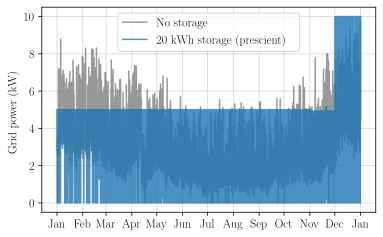

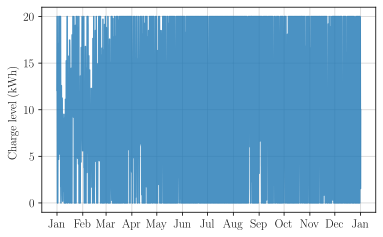

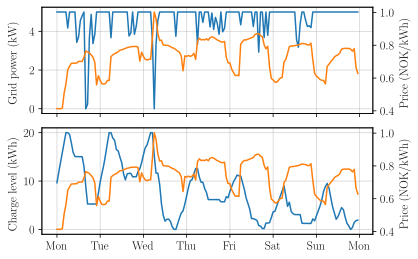

In [5]:
power_prescient = p.value

# Compute and print total cost with no storage
total_tou_cost, total_spot_cost, total_peak_cost = compute_total_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=p.value, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)
cost_prescient = total_tou_cost + total_spot_cost + total_peak_cost
print_cost_summary(total_tou_cost, total_spot_cost, total_peak_cost)

# Plot grid power
z_load = get_z_hourly_values(power=load, datetime_index=sim_datetime_index, N=3)
z_prescient = get_z_hourly_values(power=power_prescient, datetime_index=sim_datetime_index, N=3)

latexify(fig_width=6)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:gray", alpha=0.8, label="No storage")
ax.plot(sim_datetime_index, power_prescient, color="tab:blue", alpha=0.8, label="20 kWh storage (prescient)")
# ax.plot(sim_datetime_index, z_load, color="k", label="Monthly average of 3 largest daily powers")
# ax.plot(sim_datetime_index, z_prescient, color="blue", label="Monthly average of 3 largest daily powers")
plt.ylabel("Grid power (kW)")
plt.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Plot charge level
latexify(fig_width=6)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, q.value[1:], color="tab:blue", alpha=0.8)
plt.ylabel("Charge level (kWh)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Plot grid power, charge level, and electricity prices for 1 week in January
power_prescient_series = pd.Series(power_prescient, index=sim_datetime_index)
soc_prescient_series = pd.Series(q.value[1:], index=sim_datetime_index)
price_series = pd.Series(spot_prices + tou_prices, index=sim_datetime_index)
datetime_index = sim_datetime_index[(sim_datetime_index >= '2022-01-03') & (sim_datetime_index < '2022-01-10')]

latexify(fig_width=6)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(power_prescient_series[datetime_index].values, color="tab:blue")
ax[0].set_ylabel("Grid power (kW)")

ax[1].plot(soc_prescient_series[datetime_index].values, color="tab:blue")
ax[1].set_ylabel("Charge level (kWh)")
ax[1].set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax[1].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

# Plot spot_price_series on both subplots
for axis in ax:
    ax2 = axis.twinx()
    ax2.plot(price_series[datetime_index].values, color="tab:orange", linestyle="solid")
    ax2.set_ylabel("Price (NOK/kWh)")
    ax2.yaxis.tick_right()
    ax2.grid(False)

# Align y-axis labels
fig.align_ylabels(ax)
plt.tight_layout()

### Cost versus storage capacity

In [6]:
# storage_capacities = np.linspace(0, 100)

# costs = np.zeros(len(storage_capacities))
# costs_2 = np.zeros_like(costs)

# for i, capacity in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities)):
#     Q.value = capacity
#     C.value = Q.value / 2
#     D.value = Q.value / 2
#     q_init.value = Q.value / 2
#     q_final.value = Q.value / 2
    
#     problem.solve(solver=cp.GUROBI)

#     assert problem.status == cp.OPTIMAL, f"Solver failed to find an optimal solution. Problem status: {problem.status}"

#     costs[i] = cost.value
#     total_tou_cost, total_spot_cost, total_peak_cost = compute_total_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=p.value, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)
#     costs_2[i] = total_tou_cost + total_spot_cost + total_peak_cost
     
# savings_percetage = (costs[0] - costs)/costs[0] * 100
# savings_percetage_2 = (costs_2[0] - costs_2)/costs_2[0] * 100

# latexify(fig_width=6)
# plt.figure()
# plt.plot(storage_capacities, savings_percetage, color="black", linestyle="solid", label="solver cost")
# plt.plot(storage_capacities, savings_percetage_2, color="black", linestyle="dashed", label="external evaluation")
# plt.xlabel("Storage capacity (kWh)")
# plt.ylabel("Annual savings (\%)")
# plt.legend()

## Model predictive control

### Global search method

In [7]:
def calculate_peak_power_cost_and_constraints(datetime_index, p, N, N_largest_daily_powers, max_daily_power, tier_peak_costs, tier_z_upper_bounds):
    peak_power_cost = 0
    cons = []
    unique_months = pd.unique(datetime_index.month)

    for i, month in enumerate(unique_months):
        month_mask = datetime_index.month == month
        unique_days_in_month = pd.unique(datetime_index[month_mask].date)

        daily_max_powers = []

        for day in unique_days_in_month:
            day_mask = (datetime_index.date == day) & month_mask
            if max_daily_power != 0 and day == datetime_index[0].day:
                daily_max_powers.append(cp.maximum(cp.max(p[day_mask]), max_daily_power))
            else:
                daily_max_powers.append(cp.max(p[day_mask]))
        
        if month == datetime_index[0].month:
            z = cp.sum_largest(cp.hstack(daily_max_powers + N_largest_daily_powers), N) / N
        else:
            z = cp.sum_largest(cp.hstack(daily_max_powers), min(N, len(unique_days_in_month))) / min(N, len(unique_days_in_month))
        
        peak_power_cost += tier_peak_costs[i]
        cons.append(z <= tier_z_upper_bounds[i])
    
    return peak_power_cost, cons

def run_mpc(loads, spot_prices, tou_prices, datetime_index, q_init, q_final, N_largest_daily_powers, max_daily_power, H, tier_peak_costs, tier_z_upper_bounds, N=3):
    # Constants
    Q = 20
    C, D, q_final = Q/2, Q/2, Q/2
    eff_s = 0.9995 # Storage efficiency
    eff_c = 0.95 # Charging efficiency
    eff_d = 0.95 # Discharging efficiency
    P = 20 # Max power

    # Variables
    p = cp.Variable(H)  # Grid power
    u_c = cp.Variable(H)  # Charging battery power
    u_d = cp.Variable(H)  # Discharging battery power
    q = cp.Variable(H+1)  # State of charge

    # Constraints
    cons = [0 <= p, p <= P,
            loads + u_c == p + u_d,
            q[1:] == eff_s * q[:-1] + eff_c * u_c - u_d / eff_d,
            q[0] == q_init, q[-1] == q_final,
            0 <= q, q <= Q,
            0 <= u_c, u_c <= C,
            0 <= u_d, u_d <= D]

    energy_cost = cp.sum(cp.multiply(tou_prices + spot_prices, p))
    
    peak_power_cost, peak_power_cons = calculate_peak_power_cost_and_constraints(datetime_index, p, N, N_largest_daily_powers, max_daily_power, tier_peak_costs, tier_z_upper_bounds)
    cons += peak_power_cons

    cost = energy_cost + peak_power_cost
    problem = cp.Problem(cp.Minimize(cost), cons)
    problem.solve()

    return u_c.value[0], u_d.value[0], p.value[0], cost.value


t = 0
Q = 20
q_init = Q/2
H = 24*30
M, L = 24, 24
N_largest_daily_powers = []
max_daily_power = 0

tiers = [0, 1]
tier_peak_costs = np.array([147, 252])
tier_z_upper_bounds = np.array([5, 10])

def global_search(loads, spot_prices, tou_prices, datetime_index, q_init, q_final, N_largest_daily_powers, max_daily_power, H, N=3):
    
    n_months_horizon = datetime_index.to_period('M').nunique()
    
    tiers = [0, 1]
    tier_peak_costs = np.array([147, 252])
    tier_z_upper_bounds = np.array([5, 10])
    
    tier_combinations = list(itertools.product(tiers, repeat=n_months_horizon))
    
    # Global search across all possible tier combinations
    least_cost = np.inf
    u_c = None
    u_d = None
    p = None
    for combo in tier_combinations:
        _tier_peak_costs = np.array([tier_peak_costs[c] for c in combo])
        _tier_z_upper_bounds = np.array([tier_z_upper_bounds[c] for c in combo])

        try:
            u_c, u_d, p, cost = run_mpc(loads, spot_prices, tou_prices, datetime_index, q_init, q_final, N_largest_daily_powers, max_daily_power, H, _tier_peak_costs, _tier_z_upper_bounds)

            if cost < least_cost:
                least_cost = cost
                u_c = u_c
                u_d = u_d
                p = p
        except:
            continue
    
    return u_c, u_d, p


# load_forecast = make_load_forecast(load_data, load_baseline, AR_params, sim_start_time, t, H, M, L, load_min, load_max)
# spot_price_forecast = make_spot_price_forecast(spot_price_data, spot_price_baseline, sim_datetime_index, sim_start_time, t, H)
# tou_price_forecast = tou_price_data[sim_start_time+t:sim_start_time+t+H].values

# horizon_datetime_index = load_baseline.index[sim_start_time+t:sim_start_time+t+H]

# u_c, u_d, p = global_search(load_forecast, spot_price_forecast, tou_price_forecast, horizon_datetime_index, q_init, q_final, N_largest_daily_powers, max_daily_power, H)

# print(p)

In [8]:
# Constants
Q = 20
q_init = Q/2
H = 24*30
M, L = 24, 24

# Simulation window
T = 24*7#365
sim_datetime_index = load_data.index[sim_start_time:sim_start_time+T]

p_values = np.zeros(T)
q_values = np.zeros(T+1)
N_largest_daily_powers = []

max_daily_power = 0
q_values[0] = q_init
prev_datetime = sim_datetime_index[0]

# MPC loop
for t in tqdm.trange(T):
    
    # Reset N_largest_daily_powers if new month
    if prev_datetime.month != sim_datetime_index[t].month:
        N_largest_daily_powers = []
    
    # Update N_largest_daily_powers and max_daily_power
    if prev_datetime.day != sim_datetime_index[t].day:
        N_largest_daily_powers = update_N_largest_daily_powers(N_largest_daily_powers, max_daily_power)
        max_daily_power = 0
    
    # Forecast loads, time-of-use prices and day-ahead prices over a horizon H
    load_forecast = make_load_forecast(load_data, load_baseline, AR_params, sim_start_time, t, H, M, L, load_min, load_max)
    spot_price_forecast = make_spot_price_forecast(spot_price_data, spot_price_baseline, sim_datetime_index, sim_start_time, t, H)
    tou_price_forecast = tou_price_data[sim_start_time+t:sim_start_time+t+H].values
    
    # Get datetimes for the horizon
    datetime_index_horizon = load_baseline.index[sim_start_time+t:sim_start_time+t+H]
    
    # Run MPC to make a plan of actions over a horizon and get the first action of the plan
    u_c, u_d, p = global_search(load_forecast, spot_price_forecast, tou_price_forecast, datetime_index_horizon, q_values[t], q_final, N_largest_daily_powers, max_daily_power, H)

    # Execute first action and update states in the simulation
    p_values[t] = p
    q_values[t+1] =  eff_s * q_values[t] + eff_c * u_c - u_d / eff_d
    prev_datetime = sim_datetime_index[t]
    max_daily_power = np.maximum(max_daily_power, p)

100%|██████████| 168/168 [00:40<00:00,  4.15it/s]


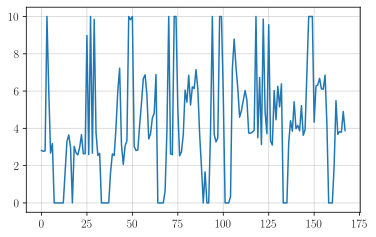

In [9]:
plt.plot(p_values[:24*7])

In [10]:
power_mpc = p_values

# Compute and print total cost with no storage
total_tou_cost, total_spot_cost, total_peak_cost = compute_total_costs(tou_prices=tou_prices, spot_prices=spot_prices, power=power_mpc, datetime_index=sim_datetime_index, peak_cost_function=tiered_peak_cost_function, N=3)
cost_mpc = total_tou_cost + total_spot_cost + total_peak_cost
print_cost_summary(total_tou_cost, total_spot_cost, total_peak_cost)

# Plot grid power
latexify(fig_width=6)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, load, color="tab:gray", alpha=0.8, label="No storage")
ax.plot(sim_datetime_index, power_mpc, color="tab:blue", alpha=0.7, label="20 kWh storage (MPC)")
ax.plot(sim_datetime_index, power_prescient, color="tab:orange", alpha=0.5, label="20 kWh storage (prescient)")
plt.ylabel("Grid power (kW)")
plt.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Plot charge level
latexify(fig_width=6)
fig, ax = plt.subplots()
ax.plot(sim_datetime_index, q_values[1:], color="tab:blue", alpha=0.8)
plt.ylabel("Charge level (kWh)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Plot grid power, charge level, and electricity prices for 1 week in January
power_mpc_series = pd.Series(power_mpc, index=sim_datetime_index)
soc_mpc_series = pd.Series(q_values[1:], index=sim_datetime_index)
price_series = pd.Series(spot_prices + tou_prices, index=sim_datetime_index)
# datetime_index = sim_datetime_index[(sim_datetime_index >= '2022-01-03') & (sim_datetime_index < '2022-01-10')]
datetime_index = sim_datetime_index[(sim_datetime_index >= '2022-01-01') & (sim_datetime_index < '2022-01-03')]

latexify(fig_width=6)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(datetime_index, power_mpc_series[datetime_index].values, color="tab:blue")
ax[0].set_ylabel("Grid power (kW)")

ax[1].plot(datetime_index, soc_mpc_series[datetime_index].values, color="tab:blue")
ax[1].set_ylabel("Charge level (kWh)")
plt.xticks(rotation=45)
ax[1].set_xticks(np.arange(0, 24 * 7 + 1, 24))
ax[1].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun", "Mon"])

# Plot spot_price_series on both subplots
for axis in ax:
    ax2 = axis.twinx()
    ax2.plot(datetime_index, price_series[datetime_index].values, color="tab:orange", linestyle="solid")
    ax2.set_ylabel("Price (NOK/kWh)")
    ax2.yaxis.tick_right()
    ax2.grid(False)

# Align y-axis labels
fig.align_ylabels(ax)
plt.tight_layout()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 8760 but corresponding boolean dimension is 168

## Cost comparison

In [ ]:
print(f"Cost without storage: {cost_no_storage:,.2f} NOK")
print(f"Prescient cost with 20 kWh of storage capacity: {cost_prescient:,.2f} NOK")
print(f"MPC cost with 20 kWh of storage capacity: {cost_mpc:,.2f} NOK")

relative_gap = (abs(cost_mpc - cost_prescient) / abs(cost_prescient)) * 100
print(f"Relative gap between MPC cost and prescient cost: {relative_gap:.2f}%")
print(f"Annual savings with MPC policy and 20 kWh of storage capacity: {cost_no_storage-cost_mpc:.2f} NOK ({100 * (cost_no_storage-cost_mpc) / cost_no_storage:.2f}%)")